This homework will build probabilistic models of the MNIST handwritten digit dataset. You will generate fake images, perform Optical Character Recognition (OCR), and perform unsupervised learning (clustering). 

## Part 1: Generative Models
Download the MNIST dataset and learn a model that generates "fake" digit images. MNIST is a collection of 70,000 28x28 grayscale images that is commonly used for testing machine learning models. It contains examples of 10 classes, the digits 0-9. You will learn a separate *generative* multivariate Gaussian model for each digit.

1. Use the code provided to download the dataset and create a smaller, imbalanced version for the assignment.
1. For each digit 0-9, fit a multivariate Gaussian to the training set using the MLE parameters. 
1. Plot a sample from each distribution. Hint: use the method `np.random.multivariate_normal`. 

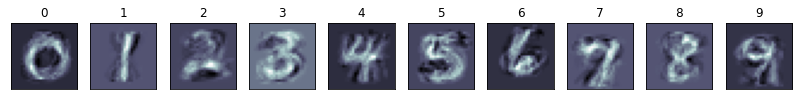

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy # Might have to install this: !conda install scipy.
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Download digit data. 70000 images of size 784 (28x28).
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X_full /= 255 # Scale between 0 and 1.
y_full = y_full.astype(int)

# To make this assignment harder, make the training set imbalanced.
to_remove = (y_full % 2 == 0).nonzero()[0][::2] 
# Indices of every other even digit.
X_full = np.delete(X_full, to_remove, axis=0)
y_full = np.delete(y_full, to_remove)

# Create train/test split.
X, X_test, y, y_test = train_test_split(X_full, y_full, 
                                        train_size=1000/len(y_full), 
                                        test_size=1000/len(y_full))

#fit the model 
gdata = np.zeros((10,X.shape[1]))
for i in range(0,10):
    num = np.where(y==i)
    sigma = np.zeros((1,784))
    for matrix in X[num]:
        sigma =matrix + sigma 
    #calculate the mean 
    mean = sigma/X[num].shape[0]
    mean = np.mean(mean, axis=0)
    cov = np.cov(X[num].T)
    gdata[i,:]=np.random.multivariate_normal(mean, cov)
# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(gdata[i,:].reshape(28,28), cmap='bone')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])


## Part 2: Classification Using Bayes Rule
Using the generative models from above, classify the test set examples. Because of the small probability density values, many of the computations must be done in log space, so I have provided code for the more challenging operations.

1. For each test set example, use Bayes Rule to compute a probability of being in each class. Hint: esimate priors with `np.histogram(y)[0]/len(y)`
1. Calculate the accuracy of the classifier on the test set. Why isn't accuracy the best metric? What would be better?

In [ ]:
# Helper functions are provided because computations must be done in log space.
import numpy as np
import matplotlib.pyplot as plt
import scipy # Might have to install this: !conda install scipy.
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scipy

def safe_log_pdf(X, mu, Sigma):
    '''
    Calculates the log pdf of examples X from a single cluster.
    Uses a regularized version of the covariance matrix.
    Args:
        X: Examples (N-by-D numpy array)
        mu: Mean (length D numpy array)
        Sigma: Covariance matrix (D-by-D numpy array)
    ''' 
    # Add regularization to avoid singular covariance matrix.
    epsilon = .1
    cov = Sigma + epsilon * np.eye(Sigma.shape[0])
    normal = scipy.stats.multivariate_normal(mean=mu, cov=cov)
    return normal.logpdf(X) # Log is necessary for small vals.

def logsumexp(x):
    '''
    Helper function for safe calculation of log(sum(exp(x))).
    See http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    '''
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

def calc_probs(X, mus, Sigmas, priors):
    '''
    Compute class probabilities for examples. 
    Args:
        X: Data matrix, N-by-D array.
        mus: Dict mapping cluster index k to D-length array.
        Sigmas: Dict mapping cluster index k to D-by-D array.
        priors: K-length array giving probability of each cluster k.
        
    Returns:
        probs: N-by-K array, where n,k is probability
               that example n is in class k.
    '''
    # First calculate log pdf for each example, cluster pair.
    # logp[i,j] = log prob density fuction of cluster j for the i-th example.
    num_examples = X.shape[0]
    num_classes = len(mus)
    logp = np.zeros((num_examples, num_classes))
    for j in range(num_classes):
        logp[:,j] = safe_log_pdf(X, mus[j], Sigmas[j])
    # Second, calculate normalized class probabilities, p(k|x).
    probs = np.zeros_like(logp)
    for i in range(num_examples):
        x = logp[i,:] + np.log(priors)
        p = np.exp(x - logsumexp(x))
        assert np.isclose(np.sum(p), 1), np.sum(p) # Make sure probabilies sum to 1.
        probs[i,:] = p
    return probs


# Download digit data. 70000 images of size 784 (28x28).
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X_full /= 255 # Scale between 0 and 1.
y_full = y_full.astype(int)

# To make this assignment harder, make the training set imbalanced.
to_remove = (y_full % 2 == 0).nonzero()[0][::2] 
# Indices of every other even digit.
X_full = np.delete(X_full, to_remove, axis=0)
y_full = np.delete(y_full, to_remove)

# Create train/test split.
X, X_test, y, y_test = train_test_split(X_full, y_full, 
                                        train_size=1000/len(y_full), 
                                        test_size=1000/len(y_full))
mean = {}
cov = {}
for i in range(10):
#fit the model 
    X_temp = X[y==i,:]
    mean[i] = np.mean(X_temp, axis=0)
    cov[i] = np.cov(X_temp.T)
priors = np.histogram(y)[0]/len(y)
prob = calc_probs(X_test, mean, cov, priors)
y_pred = np.argmax(prob, axis = 1)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, prob, multi_class='ovr'))


    


#### Why isn't accuracy the best metric? What would be better?
Accuracy is not the best metric for imbalanced sets of samples. AUC would be better choice for an imbalanced sets. 

##  Part 3: Unsupervised Learning
Use Unsupervised Learning to learn a Gaussian Mixture Model. For this part, you will *ignore* the class labels, and fit a GMM to the training data. (Do not use sklearn's GMM implementation.)

1. Randomly initialize clusters using `mus = {i:X[i,:] for i in range(K)}` and `Sigmas = {i:np.eye(784) for i in range(K)}`.
1. Update probabilistic cluster assignments. 
1. Update each cluster mean, covariance, and prior from the probabilistic cluster assignments. (Every example contributes to every class-conditional mean, cov, and prior weighted by the probability of being in that class.) 
1. Repeat these updates 100 times. 
1. Do the _learned_ clusters agree with the true labels? That is, does the machine agree with the human? Provide an argument. One way is to measure the homogeneity of each learned cluster. For example, you can assign each example to its most likely cluster, look at the true labels of the examples assigned to that cluster, and count what fraction are in the majority class.

In [ ]:
# Helper functions
def weighted_mean(X, weights):
    return np.average(X, weights=weights, axis=0)

def weighted_covariance(X, weights):
    return np.cov(X.T, aweights=weights)

def weighted_priors(weights):
    return np.sum(weights, axis=0) / weights.shape[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy # Might have to install this: !conda install scipy.
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Helper functions
def weighted_mean(X, weights):
    return np.average(X, weights=weights, axis=0)

def weighted_covariance(X, weights):
    return np.cov(X.T, aweights=weights)

def weighted_priors(weights):
    return np.sum(weights, axis=0) / weights.shape[0]

def calc_probs(X, mus, Sigmas, priors):
    '''
    Compute class probabilities for examples. 
    Args:
        X: Data matrix, N-by-D array.
        mus: Dict mapping cluster index k to D-length array.
        Sigmas: Dict mapping cluster index k to D-by-D array.
        priors: K-length array giving probability of each cluster k.
        
    Returns:
        probs: N-by-K array, where n,k is probability
               that example n is in class k.
    '''
    # First calculate log pdf for each example, cluster pair.
    # logp[i,j] = log prob density fuction of cluster j for the i-th example.
    num_examples = X.shape[0]
    num_classes = len(mus)
    logp = np.zeros((num_examples, num_classes))
    for j in range(num_classes):
        logp[:,j] = safe_log_pdf(X, mus[j], Sigmas[j])
    # Second, calculate normalized class probabilities, p(k|x).
    probs = np.zeros_like(logp)
    for i in range(num_examples):
        x = logp[i,:] + np.log(priors)
        p = np.exp(x - logsumexp(x))
        assert np.isclose(np.sum(p), 1), np.sum(p) # Make sure probabilies sum to 1.
        probs[i,:] = p
    return probs
def safe_log_pdf(X, mu, Sigma):
    '''
    Calculates the log pdf of examples X from a single cluster.
    Uses a regularized version of the covariance matrix.
    Args:
        X: Examples (N-by-D numpy array)
        mu: Mean (length D numpy array)
        Sigma: Covariance matrix (D-by-D numpy array)
    ''' 
    # Add regularization to avoid singular covariance matrix.
    epsilon = .1
    cov = Sigma + epsilon * np.eye(Sigma.shape[0])
    normal = scipy.stats.multivariate_normal(mean=mu, cov=cov)
    return normal.logpdf(X) # Log is necessary for small vals.

def logsumexp(x):
    '''
    Helper function for safe calculation of log(sum(exp(x))).
    See http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    '''
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


# Download digit data. 70000 images of size 784 (28x28).
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X_full /= 255 # Scale between 0 and 1.
y_full = y_full.astype(int)

# To make this assignment harder, make the training set imbalanced.
to_remove = (y_full % 2 == 0).nonzero()[0][::2] 
# Indices of every other even digit.
X_full = np.delete(X_full, to_remove, axis=0)
y_full = np.delete(y_full, to_remove)

# Create train/test split.
X, X_test, y, y_test = train_test_split(X_full, y_full, 
                                        train_size=1000/len(y_full), 
                                        test_size=1000/len(y_full))
K=10
mus = {i:X[i,:] for i in range(K)}
Sigmas = {i:np.eye(784) for i in range(K)}
priors = np.histogram(y)[0]/len(y)
for i in range(1000):
    weight = calc_probs(X_test, mus, Sigmas, priors)
    for j in range(10):
        mus[j] =weighted_mean(X_test,weight[:,j])
        Sigmas[j] = weighted_covariance(X_test, weight[:,j])
        priors[j] = weighted_priors(weight[:,j])
#print(weight)
y_pred = np.argmax(weight, axis = 1)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, prob, multi_class='ovr'))

plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(gdata[i,:].reshape(28,28), cmap='bone')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])